# autoTS: Wavelet Transform


**Table of contents**
* Generating Data
* Pre-processing
    * Standardization
    * Detrend
    * Detect outliers
    * Remove outliers
    * Hypothesize over missing values
* Analysis
    * Wavelet transform
    * Significance testing 

    
Functions are available through the [Pyleoclim package](https://github.com/LinkedEarth/Pyleoclim_util/tree/Development) on the development branch.

In [27]:
import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import json

In [39]:
def transform(obj_dict):
    for k in obj_dict.keys():
        if isinstance(obj_dict[k],(np.ndarray)):
            obj_dict[k] = obj_dict[k].tolist()
        elif isinstance(obj_dict[k],(pyleo.Series,pyleo.Scalogram)):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
        
        elif isinstance(obj_dict[k],pyleo.MultipleScalogram):
            obj_dict[k]=PyleoObj_to_json(obj_dict[k],dict_return=True)
            c=[]
            idx = np.arange(0,len(obj_dict[k]['scalogram_list']),1).tolist()
            for item in idx:
                PSD_dict=PyleoObj_to_json(obj_dict[k]['scalogram_list'][item],dict_return=True)
                c.append(PSD_dict)
            obj_dict[k]['scalogram_list']=c            
        elif isinstance(obj_dict[k],(dict)):
            obj_dict[k]=transform(obj_dict[k])
    return obj_dict


def list_to_array(obj_dict):
    for k in obj_dict:
        if type(obj_dict[k])is dict:
            obj_dict[k]=list_to_array(obj_dict[k])
        elif type(obj_dict[k]) is list:
            obj_dict[k]=np.array(obj_dict[k])
        else:
            obj_dict[k]=obj_dict[k]
    return obj_dict

def PyleoObj_to_json(PyleoObj,filename='trial',dict_return=False):
    obj_dict = PyleoObj.__dict__
    obj_dict = transform(obj_dict)
    if dict_return == False:
        with open('./IntermediateOutputs/'+filename+'.json','w') as f:
            json.dump(obj_dict, f)
            f.close()
    elif dict_return == True:
        return  obj_dict

def json_to_Series(filename):
    with  open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    ts = pyleo.Series(time=np.array(t['time']),
                     value=np.array(t['value']),
                     time_name=t['time_name'],
                     time_unit=t['time_unit'],
                     value_name=t['value_name'],
                     value_unit=t['value_unit'],
                     label=t['label']) 
    return ts

def Scalogram_to_MultipleScalogram(series_list):
    idx = np.arange(0,len(series_list),1).tolist()
    d=[]
    for item in idx:
        t=series_list[item]
        scalogram_obj= pyleo.Scalogram(frequency=np.array(t['frequency']),time=np.array(t['time']),
                               amplitude=np.array(t['amplitude']),coi=t['coi']
                               ,label=t['label'],timeseries=t['timeseries'],
                               wave_method = t['wave_method']
                               ,wave_args=t['wave_args'],
                               signif_qs = t['signif_qs'],
                               signif_method=t['signif_method'])

        d.append(scalogram_obj)
    mscalogram=pyleo.MultipleScalogram(scalogram_list=d)
    return mscalogram

def json_to_Scalogram(filename):
    with open('./IntermediateOutputs/'+filename+'.json','r') as f:
        t = json.load(f)
    t = list_to_array(t)
    temp = t['timeseries']
    ts = pyleo.Series(time=np.array(temp['time']),
                     value=np.array(temp['value']),
                     time_name=temp['time_name'],
                     time_unit=temp['time_unit'],
                     value_name=temp['value_name'],
                     value_unit=temp['value_unit'],
                     label=t['label'])
    c = None
    if type(t['signif_qs']) is dict:
        c = Scalogram_to_MultipleScalogram(t['signif_qs']['scalogram_list'])
    else:
        c = t['signif_qs']
                             
    scalogram = pyleo.Scalogram(frequency=np.array(t['frequency']),time=np.array(t['time']),
                               amplitude=np.array(t['amplitude']),coi=t['coi']
                               ,label=t['label'],timeseries=ts,
                               wave_method = t['wave_method']
                               ,wave_args=t['wave_args'],
                               signif_qs = c,
                               signif_method=t['signif_method'])
    return scalogram
    



## Data Generation

Here,we use synthetic timeseries for demonstration purposes. 

Pyleoclim is being extended to handle LiPD files directly. For other types of data, Pyleoclim's basic object is Series, which will need to be created as a first step.

### Step 1: Generate a signal with trend, noise and missing values

This step would be replaced by opening dataset.

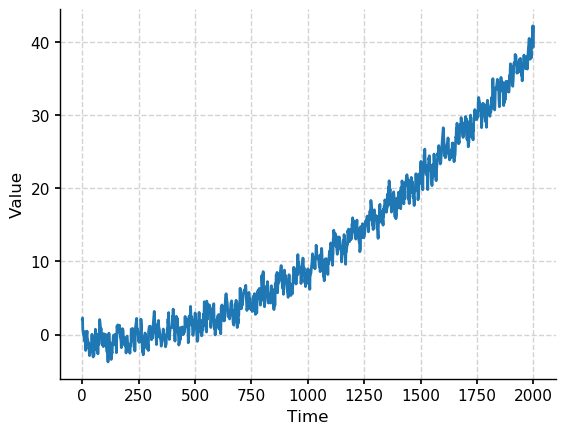

In [29]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
#freqs=[1/20]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add outliers

#outliers_start = np.mean(signal)+5*np.std(signal)
#outliers_end = np.mean(signal)+7*np.std(signal)
#outlier_values = np.arange(outliers_start,outliers_end,0.1)
#index = np.random.randint(0,len(signal),6)
#signal_out = signal
#for i,ind in enumerate(index):
#    signal_out[ind] = outlier_values[i]

# Add a non-linear trend
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
#signal_trend = signal_out + nonlinear_trend

#Add white noise
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise

#Remove data points
del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal_noise, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

### Step 2: Create a series object for Pyleoclim


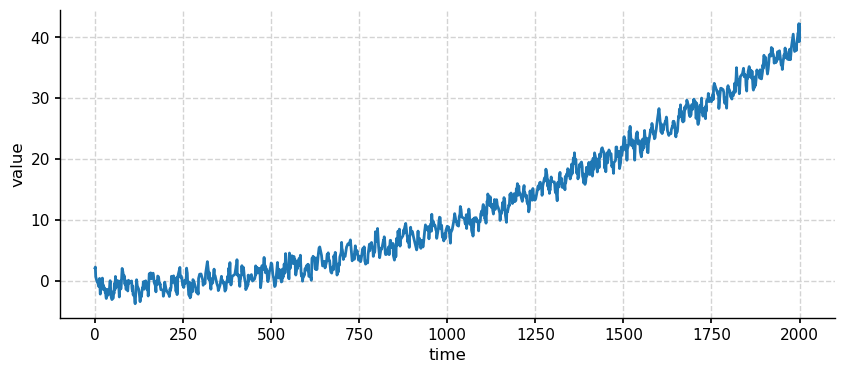

In [30]:
ts=pyleo.Series(time=time_unevenly,value=signal_unevenly)
PyleoObj_to_json(ts,'ts')
fig,ax=ts.plot()


## Preprocessing

### Standarize

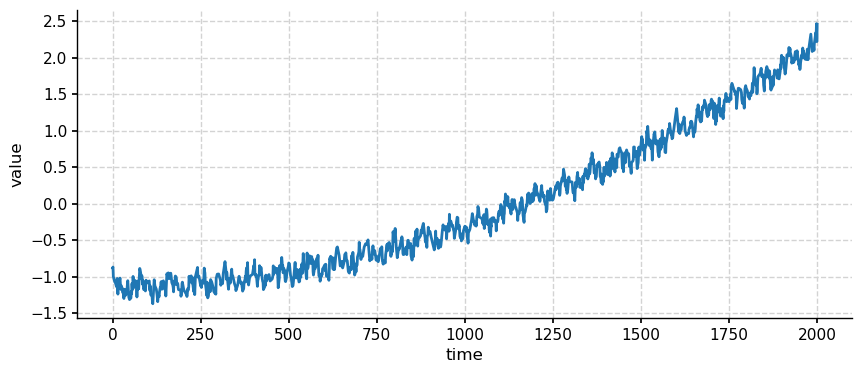

In [31]:
#%% preprocessing- standardize

ts = json_to_Series('ts')
ts_std=ts.standardize()
PyleoObj_to_json(ts_std,'ts_std')
fig,ax=ts_std.plot()

### Detrend

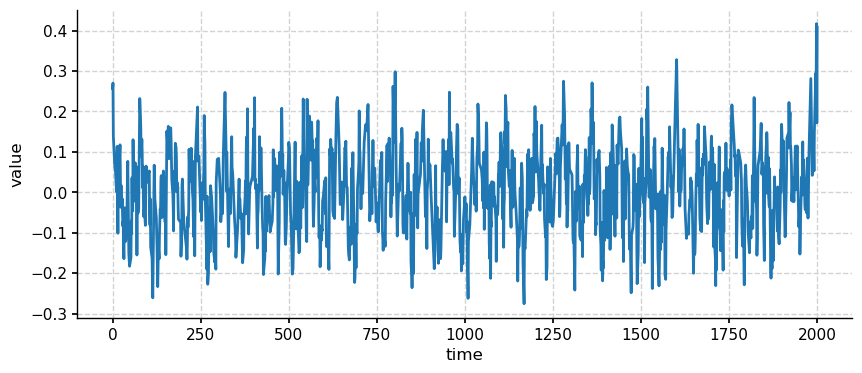

In [32]:
#%% preprocessing - detrend
ts_std = json_to_Series('ts_std') 
ts_detrended=ts_std.detrend(method='emd')
fig,ax=ts_detrended.plot()
PyleoObj_to_json(ts_detrended,'ts_detrended')

### Detect outliers and remove outliers

Based on the detected outliers, may need to remove them prior to analysis. 

In this case, the if/else could happen within the component: do nothing on else but return a similar object to be used by the next component.

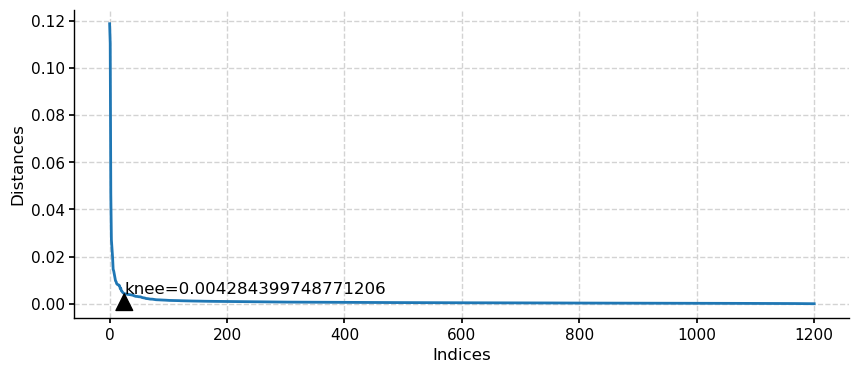

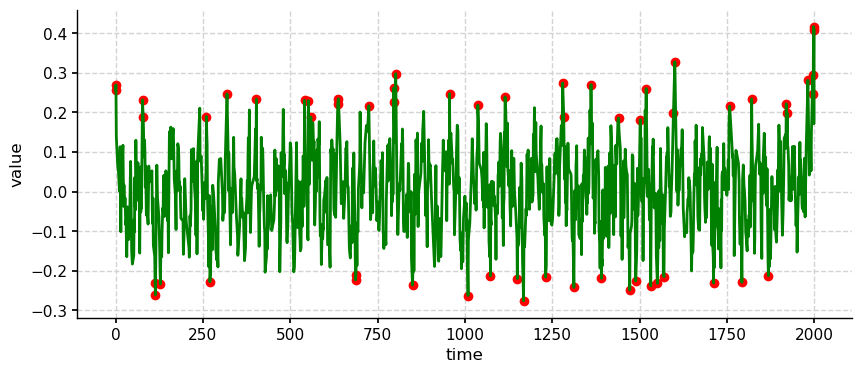

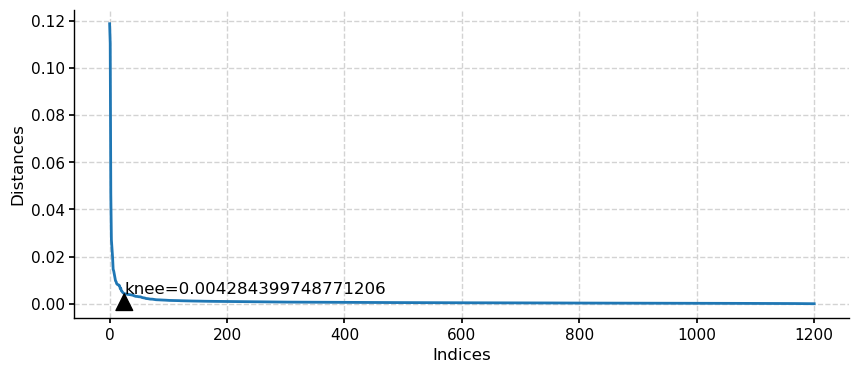

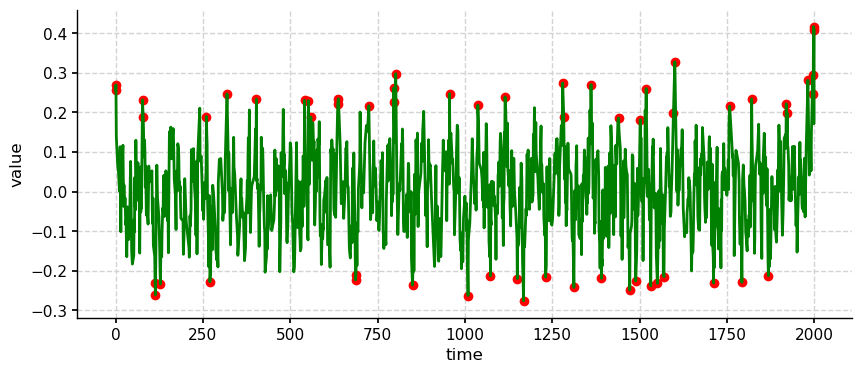

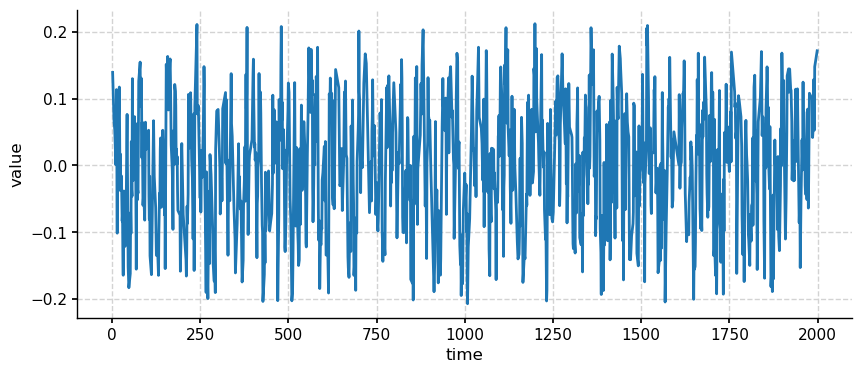

In [33]:
#%% detect and remove outliers
ts_detrended = json_to_Series('ts_detrended')
outliers=ts_detrended.outliers(remove=False)

if len(outliers)>0:
    ts_outliers = ts_detrended.outliers(remove=True)
else:
    ts_outliers=ts_detrended
PyleoObj_to_json(ts_outliers,'ts_outliers')
fig,ax=ts_outliers.plot()

### Interpolation

This example uses a linear interpolation, other methods to achieve an evenly-spaced time series are spline interpolation, binning, and singular spectrum analysis. All methods could be equally valid and should be explored.

**Rule**: if the method spectral analysis is 'Lomb-Scargle' or 'WWZ', this step should be skipped (or same timeseries returned); else, this step is necessary. 

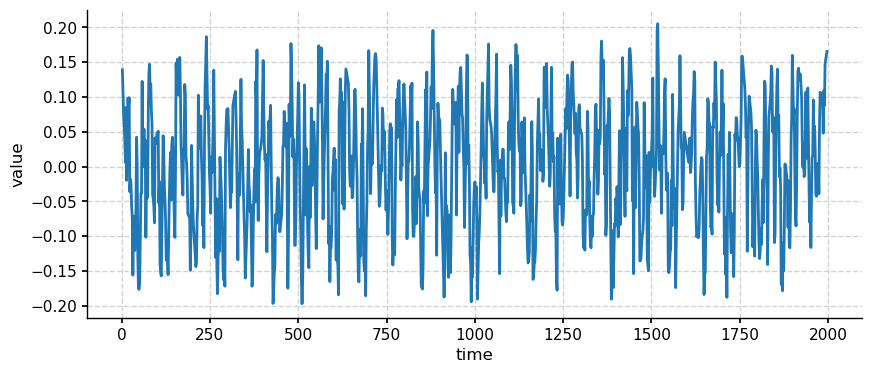

In [34]:
#%% interpolation
ts_outliers = json_to_Series('ts_outliers')
ts_interp=ts_outliers.interp(method='linear')

fig,ax=ts_interp.plot()
PyleoObj_to_json(ts_interp,'ts_interp')

### Analysis



WWZ method doesn't require require evenly-spaced data in time, and therefore  uses the detrended time series.

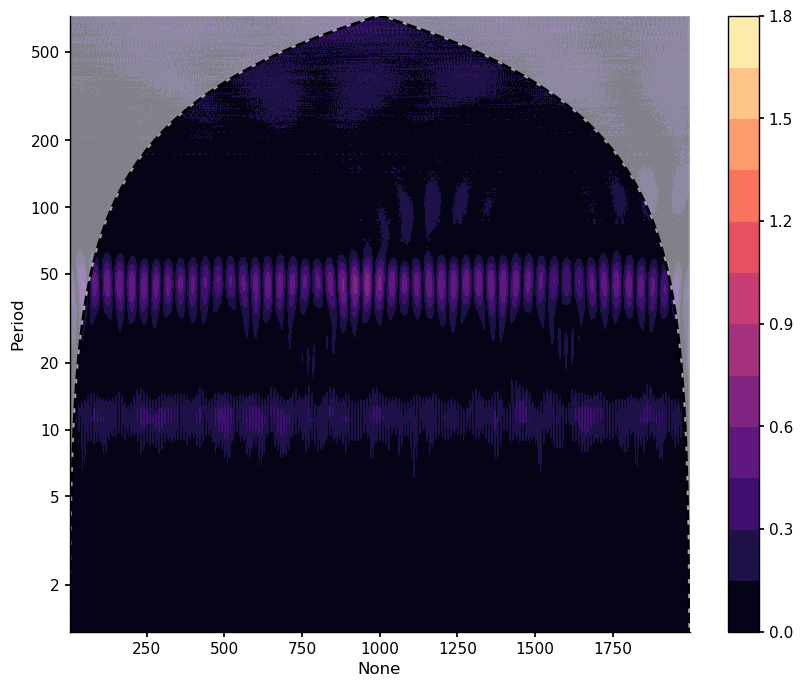

In [35]:
#%% Analysis-cwt
ts_interp = json_to_Series('ts_interp')

scales = np.arange(1, 1000) #not sure what scales to use
cwt_res=ts_interp.wavelet(method='cwt',settings={'scales':scales})

cwt_res.plot()
PyleoObj_to_json(cwt_res,'cwt_res')

Performing wavelet analysis on surrogates: 100%|██████████| 200/200 [05:18<00:00,  1.59s/it]


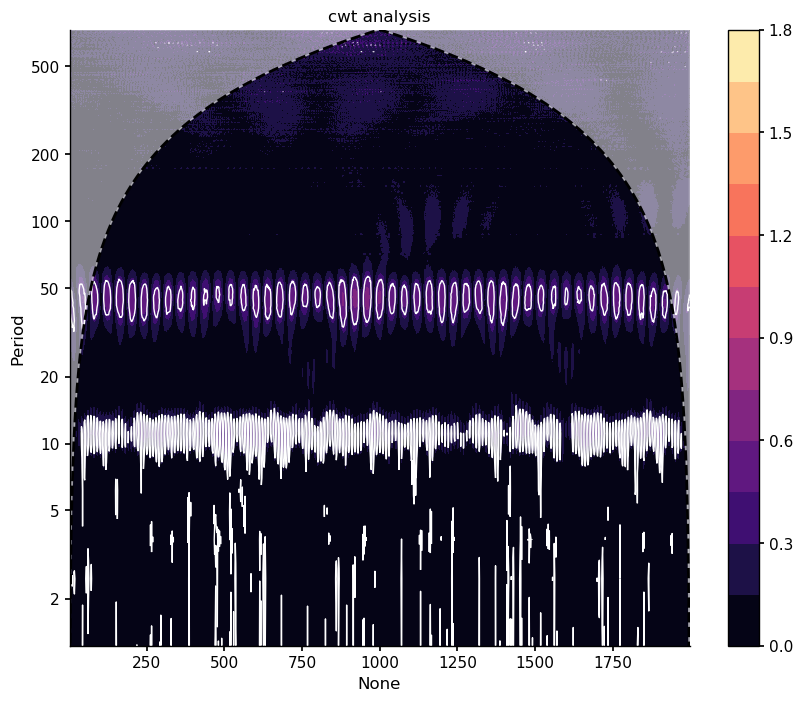

In [36]:
cwt_res =json_to_Scalogram('cwt_res')
cwt_signif=cwt_res.signif_test(qs=[0.95])
fig,ax=cwt_signif.plot(title='cwt analysis')
plt.show()
PyleoObj_to_json(cwt_signif,'cwt_signif')



In [40]:
cwt_signif = json_to_Scalogram('cwt_signif')

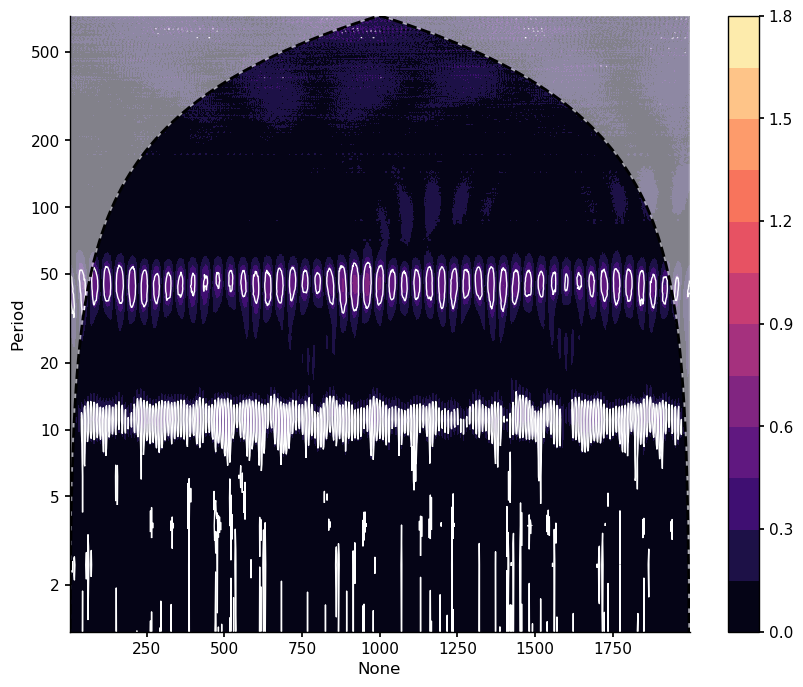

(<Figure size 1000x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9be0ddf2e0>)

In [42]:
cwt_signif.plot()

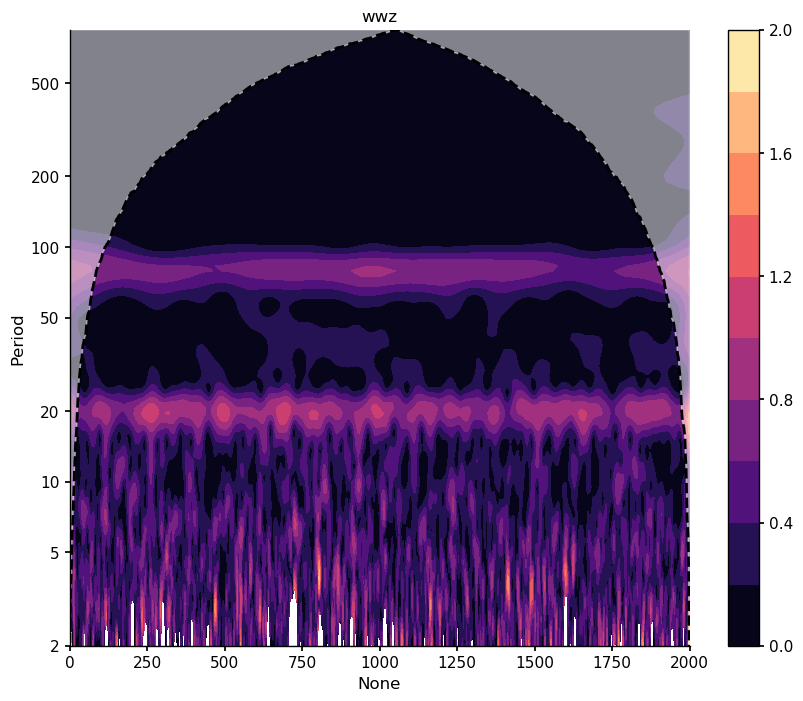

In [43]:
ts_detrended = json_to_Series('ts_detrended')
wwz_res=ts_detrended.wavelet(method='wwz',settings={})
wwz_res.plot(title='wwz')
plt.show()
PyleoObj_to_json(wwz_res,'wwz_res')

Performing wavelet analysis on surrogates: 100%|██████████| 200/200 [49:44<00:00, 14.92s/it]


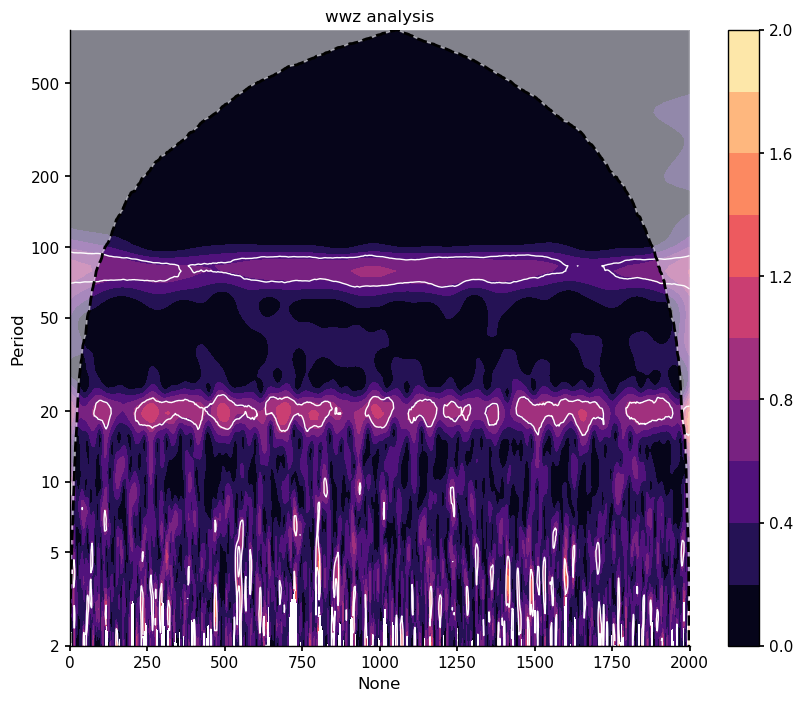

In [44]:
#%% signif test -wwz
wwz_res= json_to_Scalogram('wwz_res')
wwz_signif=wwz_res.signif_test(qs=[0.95])
fig,ax=wwz_signif.plot(title='wwz analysis')
plt.show()

In [ ]:
PyleoObj_to_json(wwz_signif,'wwz')

In [ ]:
wwz_signif = json_to_Scalogram('wwz_res')